# A Toy Problem - Enhanced Sampling

## Framing the Problem

Consider a system with two degrees of freedom with Hamiltonian:
$$
    H = \frac{px^2}{2m_x}\ + \frac{py^2}{2m_y}\ + \frac{D_0}{a^4}(x^2-a^2)^2 + \frac{1}{2}m_y\omega^2y^2 + \lambda xy
$$

We can see the potential energy is:
$$
   U(x, y) = \frac{D_0}{a^4}(x^2-a^2)^2 + \frac{1}{2}m_y\omega^2y^2 + \lambda xy 
$$

We want to calculate the marginal probability distribution function:
$$
    P(x) = \int dy e^{-\beta U(x, y)}
$$

So that we can ascertain the potential energy surface *A* of our system:
$$
    A(x) = -\frac{1}{\beta}lnP(x)

## Analytical Solution

To begin, I will calculate the marginal probability distribution analytically. This will serve as a benchmark value that I can compare to the results that I will simulate.

In [19]:
# Libraries
import numpy as np
from sympy import integrate, Symbol, exp, log, simplify
import matplotlib.pyplot as plt

In [15]:
# Function for the potential energy of the system
def potential_energy(x, y, D_0, a, omega, m_y, lam):
    '''
    Function to return the potential energy of system

    @param x : x coordinate
    @param y : y coordinate
    @return en : potential energy
    '''

    # Calculate energy
    en = ((D_0 / (a ** 4)) * ((x ** 2) - (a ** 2)) ** 2) + (0.5 * m_y * (omega ** 2) * (y ** 2)) + (lam * x * y)

    # Return energy
    return en

With a function to calculate potential energy, I will integrate analytically with respect to y to obtain the marginal probability distribution *P(x)* and, consequently, the free energy surface A(x). This will later be compared to the result obtained by am dynamics simulation.

In [13]:
# Define function to integrate and symbol
x, y, D_0, a, omega, m_y, lam, beta = Symbol('x'), Symbol('y'), Symbol('D_0'), Symbol('a'), Symbol('\omega'), Symbol('m_y'), Symbol('\lambda'), Symbol('beta')
func = exp(-beta * ((D_0 / (a ** 4)) * ((x ** 2) - (a ** 2)) ** 2) + (0.5 * m_y * (omega ** 2) * (y ** 2)) + (lam * x * y))

# Integrate with respect to y
fes = integrate(func, y)

# Print marginal
simplify(fes)

0.707106781186548*sqrt(pi)*sqrt(1/(\omega**2*m_y))*exp(-(D_0*\omega**2*beta*m_y*(-a**2 + x**2)**2 + 0.5*\lambda**2*a**4*x**2)/(\omega**2*a**4*m_y))*erfi(0.707106781186547*(\lambda*x + \omega**2*m_y*y)/sqrt(\omega**2*m_y))

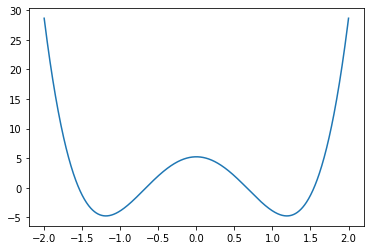

In [23]:
# Constants
D = 5
a = 1
omega = 1
m_y = 1
lam = 2.878

# Plotting Free Energy Surface
x = np.linspace(-2, 2, 1000)
z = np.log(1.25331 * np.exp(((D * (x ** 2 - a ** 2) ** 2) / (a ** 4)) - ((0.5 * (x ** 2) * (lam ** 2)) / (m_y * (omega ** 2)))) / (np.sqrt(m_y) * omega))
plt.plot(x, z)

## Choice of Integrator

Since I am using a Langevian Thermostat, I will be implementing the Stochastic position Verlet (SPV) integrator. 

## Numerical Solution

A numerical solution requires simulating a particle in the x and y space we have constrained our system to. In order to do this we must initialize a system with x and y coordinates at time of 0 seconds. We also need to specify temperature and masses for x and y directions.

In [28]:
def run_simulation(n_steps, m_x, t_x):
    '''
    Function to run simulation for x timesteps

    @param n_steps : number of timesteps to take
    @param m_x : mass for x-coordinate
    @param t_x : temperature for x-coordinate
    '''

    # Initialize system
    coords = (-1, 1)
    velocity = 
    

def update(coords)